In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow as tf

# Desactivar la ejecución ansiosa
tf.compat.v1.disable_eager_execution()

# Definir las características
batch_size = 128
input_channels = 96
output_channels = 256
kernel_size = (7, 7)
input_size = (40, 40)

# Crear un placeholder para la entrada (batch_size, height, width, channels)
input_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(batch_size, input_size[0], input_size[1], input_channels))

# Definir la capa convolucional
conv_layer = tf.keras.layers.Conv2D(filters=output_channels, kernel_size=kernel_size, strides=(1, 1), padding='valid', activation=tf.nn.relu)

# Pasar la entrada a través de la capa convolucional
output = conv_layer(input_placeholder)

# Inicializar TensorFlow
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

# Simular datos de entrada
import numpy as np
input_data = np.random.rand(batch_size, input_size[0], input_size[1], input_channels)

# Ejecutar la sesión para obtener la salida
output_data = sess.run(output, feed_dict={input_placeholder: input_data})

# Imprimir la forma de la salida
print("Shape of the output:", output_data.shape)


Shape of the output: (128, 34, 34, 256)


In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()


# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
features = features
testFeatures = testFeatures
onehot_testLabels = np.zeros((testLabels.shape[0], 10))
onehot_testLabels[np.arange(testLabels.shape[0]), testLabels] = 1
testLabels = onehot_testLabels

# Set the parameters:
NumClasses = 10
BatchLength = 16
Size = [28, 28, 1]
NumIteration = 40001
LearningRate = 1e-4
EvalFreq = 1000
NumKernels = [16, 32, 64]


# spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real*real+imag*imag > 0.1, tf.float32)*real, tf.cast(real*real+imag*imag > 0.1, tf.float32)*imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0], [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0], [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8), in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)# Con estas líneas utilizando tf.keras.layers.BatchNormalization
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.int32, [None, NumClasses])  # the expected outputs, labels


# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
# Transponer solo si el tensor tiene más de 2 dimensiones
if len(Size) > 2:
    CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0]//2), int(Size[1]//2)], axis=[1, 2])
CurrentFilters = Size[-1]
# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])
with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1]*CurrentShape[2]*CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)


with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))


with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)


with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))


Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as Sess:
    Sess.run(Init)
    Step = 1
    while Step < NumIteration:
        UsedInBatch = random.sample(range(features.shape[0]), BatchLength)
        batch_xs = features[UsedInBatch, :]
        batch_ys = labels[UsedInBatch, :]
        batch_xs = np.reshape(batch_xs, [BatchLength]+Size)
        _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
        if (Step % 100) == 0:
            print("Iteration: "+str(Step))
            print("Accuracy:" + str(Acc))
            print("Loss:" + str(L))
        if (Step % EvalFreq) == 0:
            SumAcc = 0.0
            for i in range(0, testFeatures.shape[0]):
                batch_xs = testFeatures[i, :]
                batch_ys = testLabels[i, :]
                batch_xs = np.reshape(batch_xs, [1]+Size)
                batch_ys = np.reshape(batch_ys, [1, NumClasses])
                a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
                SumAcc += a
        Step += 1

Shape of w_r: (14, 14, 1, 16)
Shape of w_i: (14, 14, 1, 16)
Shape of w_r: (7, 7, 16, 32)
Shape of w_i: (7, 7, 16, 32)
Shape of w_r: (3, 3, 32, 64)
Shape of w_i: (3, 3, 32, 64)


KeyboardInterrupt: 

In [ ]:
pip install matplotlib

# RECONOCIMIENTO DE DÍGITOS


Instructions for updating:
non-resource variables are not supported in the long term


11490434/11490434 [==============================] - 0s 0us/step


Instructions for updating:
Colocations handled automatically by placer.


Iteration: 100
Accuracy:0.75
Loss:0.9918293
Iteration: 200
Accuracy:0.8125
Loss:0.6839671
Iteration: 300
Accuracy:0.875
Loss:0.6084644
Iteration: 400
Accuracy:0.875
Loss:0.5072206
Iteration: 500
Accuracy:0.875
Loss:0.78939074
Iteration: 600
Accuracy:0.5
Loss:0.7576557
Iteration: 700
Accuracy:0.625
Loss:1.6827052
Iteration: 800
Accuracy:0.625
Loss:0.633459
Iteration: 900
Accuracy:0.9375
Loss:0.30545402
Iteration: 1000
Accuracy:0.875
Loss:0.37772775
Iteration: 1100
Accuracy:0.875
Loss:0.5236139
Iteration: 1200
Accuracy:0.6875
Loss:0.6733779
Iteration: 1300
Accuracy:0.8125
Loss:0.7357676
Iteration: 1400
Accuracy:1.0
Loss:0.17974703
Iteration: 1500
Accuracy:0.9375
Loss:0.35817
Iteration: 1600
Accuracy:0.875
Loss:0.6131004
Iteration: 1700
Accuracy:0.6875
Loss:1.2689174
Iteration: 1800
Accuracy:0.75
Loss:0.540004
Iteration: 1900
Accuracy:0.875
Loss:0.6912333
Iteration: 2000
Accuracy:0.9375
Loss:0.3474351
Iteration: 2100
Accuracy:0.9375
Loss:0.17888182
Iteration: 2200
Accuracy:0.75
Loss:1.487

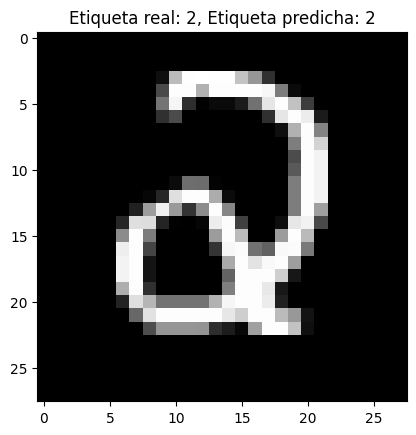

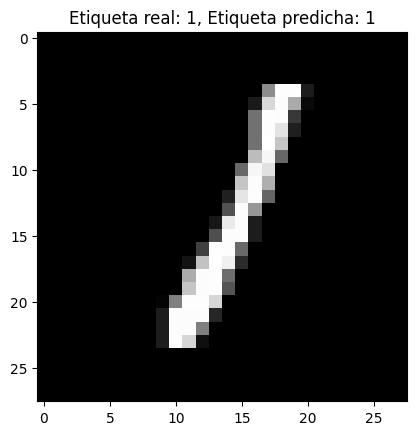

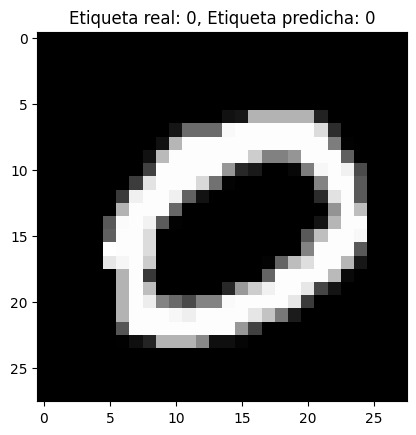

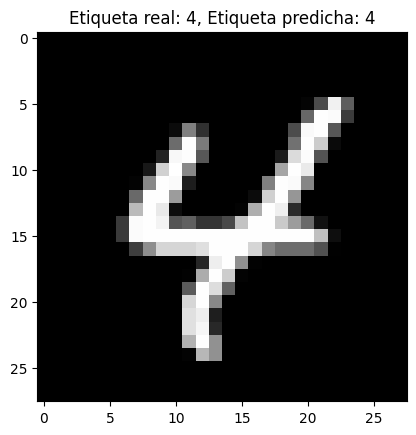

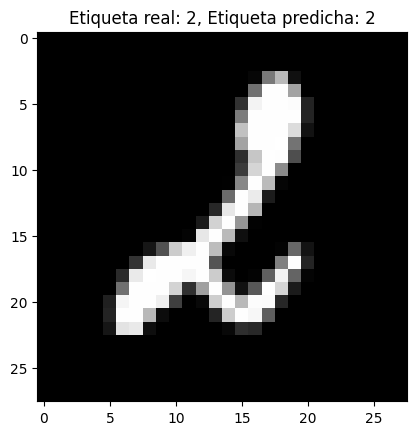

In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
from tensorflow import keras

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
features = features
testFeatures = testFeatures
onehot_testLabels = np.zeros((testLabels.shape[0], 10))
onehot_testLabels[np.arange(testLabels.shape[0]), testLabels] = 1
testLabels = onehot_testLabels

# Set the parameters:
NumClasses = 10
BatchLength = 16
Size = [28, 28, 1]
NumIteration = 40001
LearningRate = 1e-4
EvalFreq = 1000
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)# Con estas líneas utilizando tf.keras.layers.BatchNormalization
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.int32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    Step = 1
    while Step < NumIteration:
        UsedInBatch = random.sample(range(features.shape[0]), BatchLength)
        batch_xs = features[UsedInBatch, :]
        batch_ys = labels[UsedInBatch, :]
        batch_xs = np.reshape(batch_xs, [BatchLength] + Size)
        _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
        if (Step % 100) == 0:
            print("Iteration: " + str(Step))
            print("Accuracy:" + str(Acc))
            print("Loss:" + str(L))
        Step += 1

    # Después de imprimir la forma de la salida
    print("Forma de la salida:", FC.shape)

    # Visualizar algunas imágenes y sus predicciones
    num_visualize = 5  # Puedes ajustar el número de imágenes a visualizar

    # Seleccionar aleatoriamente algunas muestras del conjunto de prueba
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Crear una sesión sin inicializar explícitamente las variables
    for i in visualize_indices:
        # Obtener la imagen y la etiqueta verdadera
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocesar la entrada para que sea compatible con la red neuronal
        input_image = np.reshape(input_image, [1] + Size)

        # Obtener la predicción del modelo
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualizar la imagen, la etiqueta verdadera y la predicción
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Etiqueta real: {np.argmax(true_label)}, Etiqueta predicha: {prediction[0]}')
        plt.show()
        plt.pause(2)  # Pausa de 2 segundos entre imágenes


# GRÁFICAS


Iteration: 100
Accuracy:0.5
Loss:1.8953904
Iteration: 200
Accuracy:0.6875
Loss:0.89275205
Forma de la salida: (16, 10)


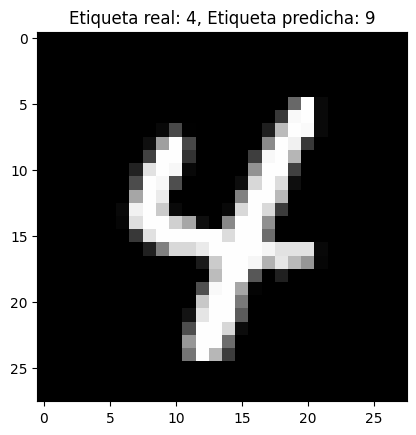

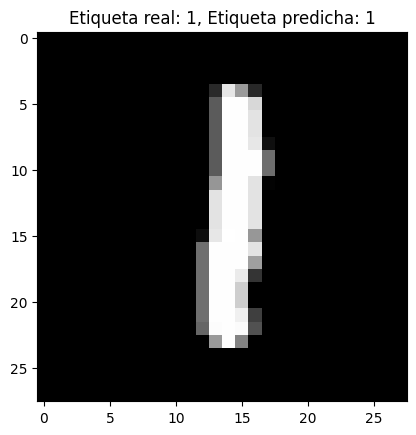

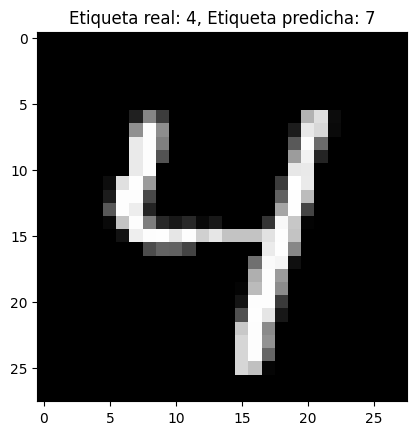

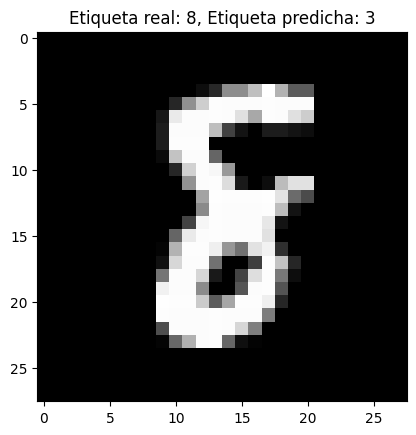

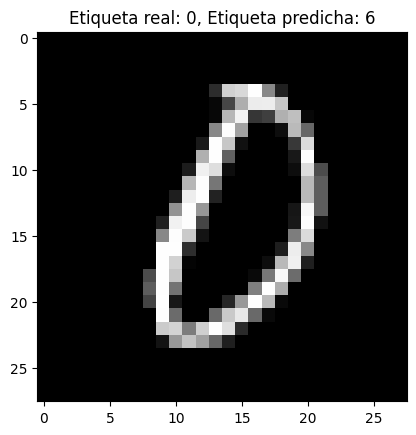

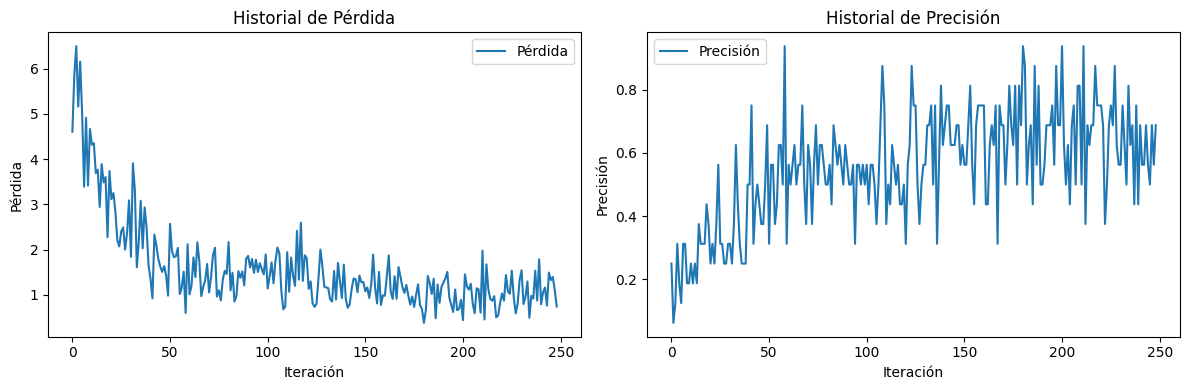

In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
from tensorflow import keras

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
features = features
testFeatures = testFeatures
onehot_testLabels = np.zeros((testLabels.shape[0], 10))
onehot_testLabels[np.arange(testLabels.shape[0]), testLabels] = 1
testLabels = onehot_testLabels

# Set the parameters:
NumClasses = 10
BatchLength = 16
Size = [28, 28, 1]
NumIteration = 250
LearningRate = 1e-4
EvalFreq = 1000
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)  # Con estas líneas utilizando tf.keras.layers.BatchNormalization
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.int32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Crear listas para almacenar la pérdida y la precisión
loss_history = []
accuracy_history = []

Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    Step = 1
    while Step < NumIteration:
        UsedInBatch = random.sample(range(features.shape[0]), BatchLength)
        batch_xs = features[UsedInBatch, :]
        batch_ys = labels[UsedInBatch, :]
        batch_xs = np.reshape(batch_xs, [BatchLength] + Size)
        _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

        # Agregar pérdida y precisión a las listas
        loss_history.append(L)
        accuracy_history.append(Acc)

        if (Step % 100) == 0:
            print("Iteration: " + str(Step))
            print("Accuracy:" + str(Acc))
            print("Loss:" + str(L))

        if (Step % EvalFreq) == 0:
            SumAcc = 0.0
            for i in range(0, testFeatures.shape[0]):
                batch_xs = testFeatures[i, :]
                batch_ys = testLabels[i, :]
                batch_xs = np.reshape(batch_xs, [1] + Size)
                batch_ys = np.reshape(batch_ys, [1, NumClasses])
                a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
                SumAcc += a
            print("Independent Test set: " + str(float(SumAcc) / testFeatures.shape[0]))

        Step += 1

    # Después de imprimir la forma de la salida
    print("Forma de la salida:", FC.shape)

    # Visualizar algunas imágenes y sus predicciones
    num_visualize = 5  # Puedes ajustar el número de imágenes a visualizar

    # Seleccionar aleatoriamente algunas muestras del conjunto de prueba
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Crear una sesión sin inicializar explícitamente las variables
    for i in visualize_indices:
        # Obtener la imagen y la etiqueta verdadera
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocesar la entrada para que sea compatible con la red neuronal
        input_image = np.reshape(input_image, [1] + Size)

        # Obtener la predicción del modelo
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualizar la imagen, la etiqueta verdadera y la predicción
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Etiqueta real: {np.argmax(true_label)}, Etiqueta predicha: {prediction[0]}')
        plt.show()
        plt.pause(2)  # Pausa de 2 segundos entre imágenes

# Graficar la pérdida y la precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Pérdida')
plt.title('Historial de Pérdida')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Precisión')
plt.title('Historial de Precisión')
plt.xlabel('Iteración')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


# CONVOLUCIONES DIRECTAS


## Falta comparaciones de tiempo en realidad.

#PRUEBAS

Iteration: 100
Accuracy:0.75
Loss:0.7880461
Iteration: 200
Accuracy:0.625
Loss:1.3505743
Iteration: 300
Accuracy:0.625
Loss:0.8861348
Iteration: 400
Accuracy:0.5
Loss:1.9265335
Iteration: 500
Accuracy:0.4375
Loss:1.456219
Iteration: 600
Accuracy:0.625
Loss:1.2649405
Iteration: 700
Accuracy:0.625
Loss:0.9126154
Iteration: 800
Accuracy:0.6875
Loss:0.74912333
Iteration: 900
Accuracy:0.625
Loss:0.99015117
Iteration: 1000
Accuracy:0.625
Loss:1.4081223
Independent Test set: 0.6067
Iteration: 1100
Accuracy:0.5
Loss:1.4056714
Iteration: 1200
Accuracy:0.8125
Loss:0.52215254
Iteration: 1300
Accuracy:0.75
Loss:0.92435473
Iteration: 1400
Accuracy:0.6875
Loss:0.88899004
Iteration: 1500
Accuracy:0.8125
Loss:0.7696641
Iteration: 1600
Accuracy:0.6875
Loss:1.1100335
Iteration: 1700
Accuracy:0.5625
Loss:1.4748454
Iteration: 1800
Accuracy:0.8125
Loss:0.7815427
Iteration: 1900
Accuracy:0.8125
Loss:0.6011188
Forma de la salida: (16, 10)


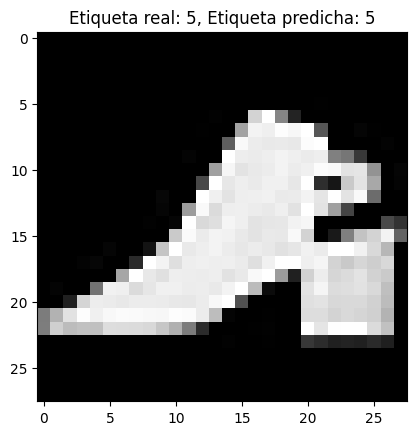

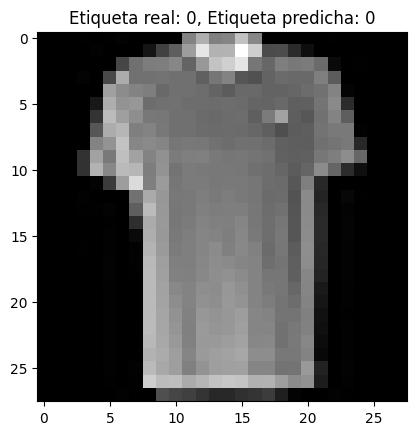

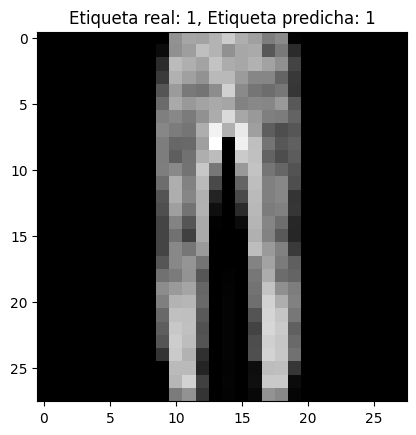

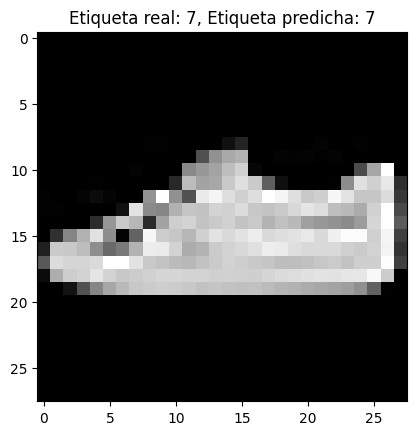

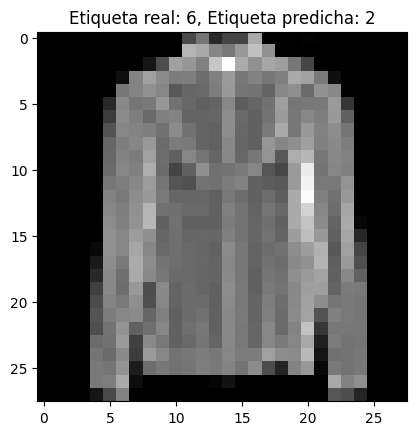

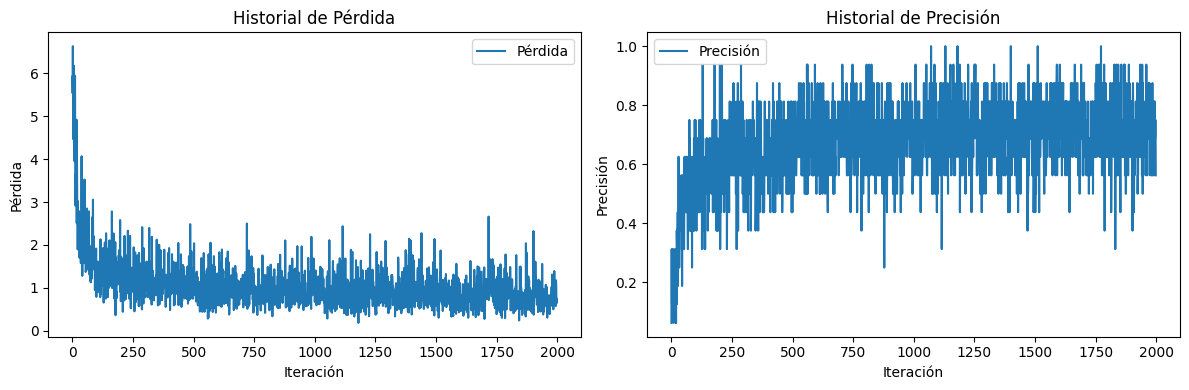

In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (Fashion MNIST dataset):
dataLoader = keras.datasets.fashion_mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
features = features
testFeatures = testFeatures
onehot_testLabels = np.zeros((testLabels.shape[0], 10))
onehot_testLabels[np.arange(testLabels.shape[0]), testLabels] = 1
testLabels = onehot_testLabels

# Set the parameters:
NumClasses = 10
BatchLength = 16
Size = [28, 28, 1]
NumIteration = 2000
LearningRate = 1e-4
EvalFreq = 1000
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)  # Con estas líneas utilizando tf.keras.layers.BatchNormalization
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.int32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Crear listas para almacenar la pérdida y la precisión
loss_history = []
accuracy_history = []

Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    Step = 1
    while Step < NumIteration:
        UsedInBatch = random.sample(range(features.shape[0]), BatchLength)
        batch_xs = features[UsedInBatch, :]
        batch_ys = labels[UsedInBatch, :]
        batch_xs = np.reshape(batch_xs, [BatchLength] + Size)
        _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

        # Agregar pérdida y precisión a las listas
        loss_history.append(L)
        accuracy_history.append(Acc)

        if (Step % 100) == 0:
            print("Iteration: " + str(Step))
            print("Accuracy:" + str(Acc))
            print("Loss:" + str(L))

        if (Step % EvalFreq) == 0:
            SumAcc = 0.0
            for i in range(0, testFeatures.shape[0]):
                batch_xs = testFeatures[i, :]
                batch_ys = testLabels[i, :]
                batch_xs = np.reshape(batch_xs, [1] + Size)
                batch_ys = np.reshape(batch_ys, [1, NumClasses])
                a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
                SumAcc += a
            print("Independent Test set: " + str(float(SumAcc) / testFeatures.shape[0]))

        Step += 1

    # Después de imprimir la forma de la salida
    print("Forma de la salida:", FC.shape)

    # Visualizar algunas imágenes y sus predicciones
    num_visualize = 5  # Puedes ajustar el número de imágenes a visualizar

    # Seleccionar aleatoriamente algunas muestras del conjunto de prueba
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Crear una sesión sin inicializar explícitamente las variables
    for i in visualize_indices:
        # Obtener la imagen y la etiqueta verdadera
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocesar la entrada para que sea compatible con la red neuronal
        input_image = np.reshape(input_image, [1] + Size)

        # Obtener la predicción del modelo
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualizar la imagen, la etiqueta verdadera y la predicción
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Etiqueta real: {np.argmax(true_label)}, Etiqueta predicha: {prediction[0]}')
        plt.show()
        plt.pause(2)  # Pausa de 2 segundos entre imágenes

# Graficar la pérdida y la precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Pérdida')
plt.title('Historial de Pérdida')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Precisión')
plt.title('Historial de Precisión')
plt.xlabel('Iteración')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

 # NÚMERO EPOCAS


In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (Fashion MNIST dataset):
dataLoader = keras.datasets.fashion_mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
features = features
testFeatures = testFeatures
onehot_testLabels = np.zeros((testLabels.shape[0], 10))
onehot_testLabels[np.arange(testLabels.shape[0]), testLabels] = 1
testLabels = onehot_testLabels

# Set the parameters:
NumClasses = 10
BatchLength = 16
Size = [28, 28, 1]
NumEpochs = 10  # Número de épocas deseado
LearningRate = 1e-4
EvalFreq = 1000
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)  # Con estas líneas utilizando tf.keras.layers.BatchNormalization
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.int32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Crear listas para almacenar la pérdida y la precisión
loss_history = []
accuracy_history = []

Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    Step = 1
    for epoch in range(NumEpochs):
        # Generar un índice aleatorio y barajarlo
        random_index = np.arange(features.shape[0])
        np.random.shuffle(random_index)

        # Bucle para iterar sobre el conjunto de entrenamiento utilizando el índice aleatorio
        for start in range(0, total_samples, BatchLength):
            end = start + BatchLength
            batch_indices = random_index[start:end]

            # Seleccionar lotes aleatorios utilizando el índice generado
            batch_xs = features[batch_indices, :]
            batch_ys = labels[batch_indices, :]
            batch_xs = np.reshape(batch_xs, [BatchLength] + Size)

            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            # Agregar pérdida y precisión a las listas
            loss_history.append(L)
            accuracy_history.append(Acc)

            if (Step % 100) == 0:
                print("Epoch: {}, Iteration: {}".format(epoch + 1, Step))
                print("Accuracy:" + str(Acc))
                print("Loss:" + str(L))

            if (Step % EvalFreq) == 0:
                SumAcc = 0.0
                for i in range(0, testFeatures.shape[0]):
                    batch_xs = testFeatures[i, :]
                    batch_ys = testLabels[i, :]
                    batch_xs = np.reshape(batch_xs, [1] + Size)
                    batch_ys = np.reshape(batch_ys, [1, NumClasses])
                    a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
                    SumAcc += a
                print("Independent Test set: " + str(float(SumAcc) / testFeatures.shape[0]))

            Step += 1

    # Después de imprimir la forma de la salida
    print("Forma de la salida:", FC.shape)

    # Visualizar algunas imágenes y sus predicciones
    num_visualize = 5  # Puedes ajustar el número de imágenes a visualizar

    # Seleccionar aleatoriamente algunas muestras del conjunto de prueba
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Crear una sesión sin inicializar explícitamente las variables
    for i in visualize_indices:
        # Obtener la imagen y la etiqueta verdadera
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocesar la entrada para que sea compatible con la red neuronal
        input_image = np.reshape(input_image, [1] + Size)

        # Obtener la predicción del modelo
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualizar la imagen, la etiqueta verdadera y la predicción
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Etiqueta real: {np.argmax(true_label)}, Etiqueta predicha: {prediction[0]}')
        plt.show()
        plt.pause(2)  # Pausa de 2 segundos entre imágenes

# Graficar la pérdida y la precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Pérdida')
plt.title('Historial de Pérdida')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Precisión')
plt.title('Historial de Precisión')
plt.xlabel('Iteración')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


# FASHION CON EPOCAS

epoca
9.540982
8.155752
7.055095
6.336835
5.3736587
4.5594854
4.7140155
3.767756
3.6599443
3.762139
3.7850187
3.1073523
2.9138782
3.0609174
2.7848418
2.6659322
2.7153106
2.3743618
2.4914336
2.6024747
2.3936877
2.3276732
2.2821746
2.0088394
2.160755
2.0857751
1.8749845
1.8946271
1.9380292
1.819306
1.6819072
1.8382353
1.9084914
1.8359896
1.7126998
1.7307271
1.5054727
1.646821
1.7646761
1.5566751
1.6523188
1.4828776
1.691987
1.521975
1.6208559
1.5815318
1.483817
1.5174702
1.5009061
1.4264516
1.4418052
1.4222277
1.434852
1.4692857
1.4074576
1.3624986
1.3002504
1.4389503
1.3624806
1.1947379
1.2684426
1.3380628
1.1813629
1.2327591
1.2936959
1.3103353
1.3385298
1.363852
1.3163258
1.2367759
1.2169598
1.2463655
1.2440968
1.238381
1.2291158
1.2619476
1.146483
1.1771798
1.1820167
1.2272276
1.1029077
1.1087105
1.2718396
1.1830235
1.1386796
1.0711523
1.0777953
1.1495268
1.2176257
1.1443512
1.0929736
1.1676915
1.1236145
1.1328532
1.1746216
1.1400272
1.077488
1.1526265
1.1158648
1.1355261
Forma de la

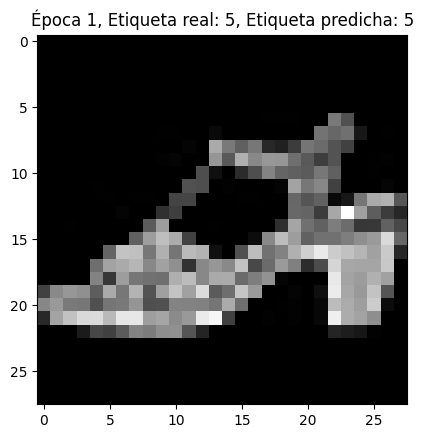

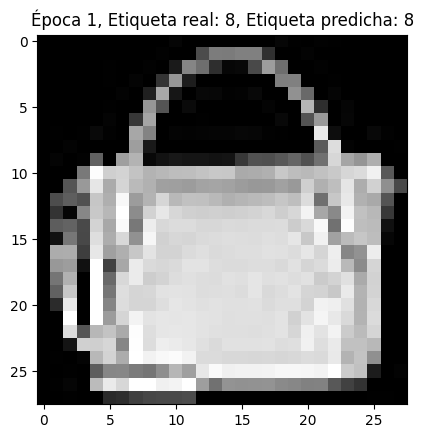

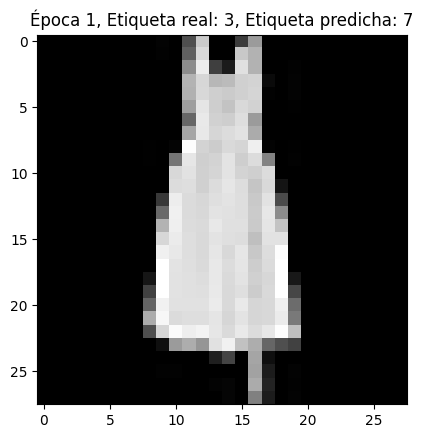

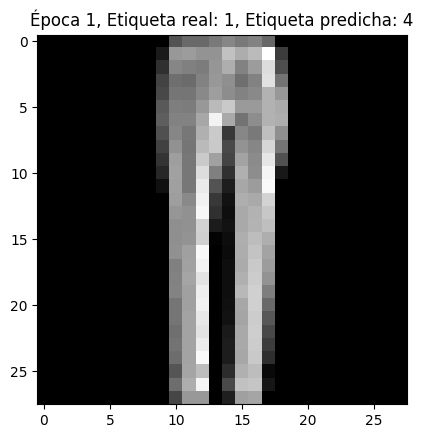

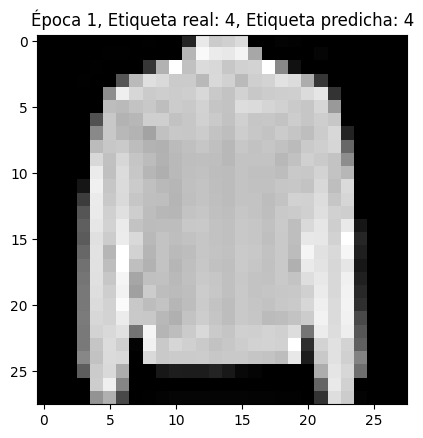

In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (Fashion MNIST dataset):
dataLoader = keras.datasets.fashion_mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
features = features
testFeatures = testFeatures
onehot_testLabels = np.zeros((testLabels.shape[0], 10))
onehot_testLabels[np.arange(testLabels.shape[0]), testLabels] = 1
testLabels = onehot_testLabels

# Set the parameters:
NumClasses = 10
BatchLength = 600
Size = [28, 28, 1]
NumIteration = 5
LearningRate = 1e-4
EvalFreq = 1000
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)  # Con estas líneas utilizando tf.keras.layers.BatchNormalization
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.int32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Crear listas para almacenar la pérdida y la precisión
loss_history = []
accuracy_history = []

# Dividir conjunto de entrenamiento y conjunto de prueba
split_ratio = 1.0
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Barajar y dividir conjunto de entrenamiento en lotes
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print('epoca')
        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
            print(L)
            # Agregar pérdida y precisión a las listas
            #loss_history.append(L)
            #accuracy_history.append(Acc)


    # Después de imprimir la forma de la salida
    print("Forma de la salida:", FC.shape)

    # Visualizar algunas imágenes y sus predicciones
    num_visualize = 5  # Puedes ajustar el número de imágenes a visualizar

    # Seleccionar aleatoriamente algunas muestras del conjunto de prueba
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Crear una sesión sin inicializar explícitamente las variables
    for i in visualize_indices:
        # Obtener la imagen y la etiqueta verdadera
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocesar la entrada para que sea compatible con la red neuronal
        input_image = np.reshape(input_image, [1] + Size)

        # Obtener la predicción del modelo
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualizar la imagen, la etiqueta verdadera y la predicción
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Época {epoch}, Etiqueta real: {np.argmax(true_label)}, Etiqueta predicha: {prediction[0]}')
        plt.show()
        plt.pause(2)  # Pausa de 2 segundos entre imágenes


Época 1
Pérdida promedio: 1.0186693668365479, Precisión promedio: 0.6829833984375
Época 2
Pérdida promedio: 0.778180718421936, Precisión promedio: 0.7412499785423279
Época 3
Pérdida promedio: 0.7439707517623901, Precisión promedio: 0.7512833476066589
Época 4
Pérdida promedio: 0.7250156998634338, Precisión promedio: 0.754883348941803
Época 5
Pérdida promedio: 0.7103959918022156, Precisión promedio: 0.7598832845687866
Época 6
Pérdida promedio: 0.6993978023529053, Precisión promedio: 0.7636333703994751
Época 7
Pérdida promedio: 0.6887211203575134, Precisión promedio: 0.7651333212852478
Época 8
Pérdida promedio: 0.6817650198936462, Precisión promedio: 0.7666332721710205
Época 9
Pérdida promedio: 0.6790517568588257, Precisión promedio: 0.7690333127975464
Época 10
Pérdida promedio: 0.6743625402450562, Precisión promedio: 0.7710832953453064
Época 11
Pérdida promedio: 0.6701956987380981, Precisión promedio: 0.7720333337783813
Época 12
Pérdida promedio: 0.6685922145843506, Precisión promedio: 0

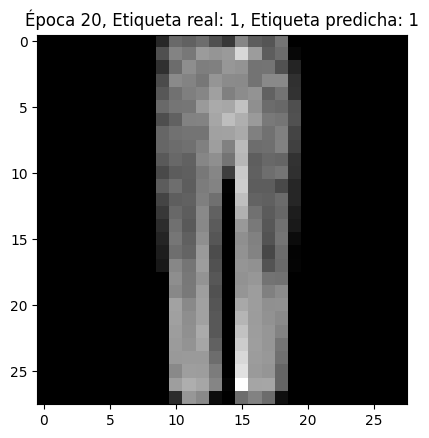

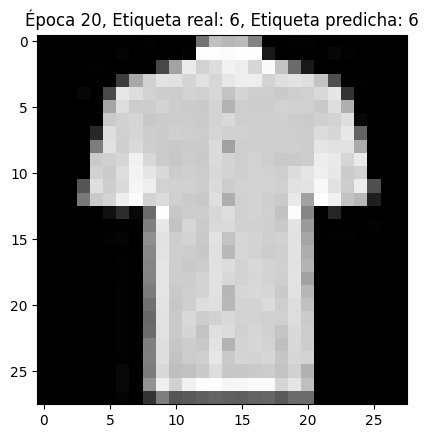

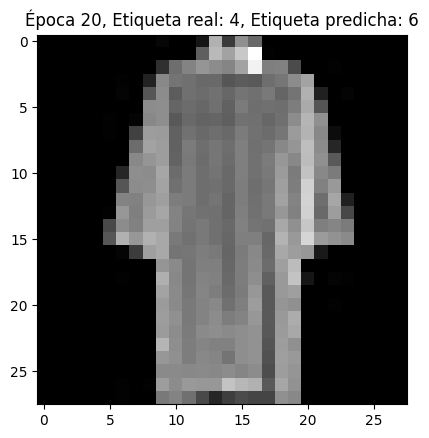

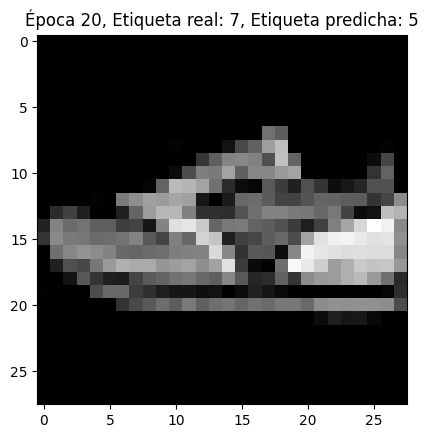

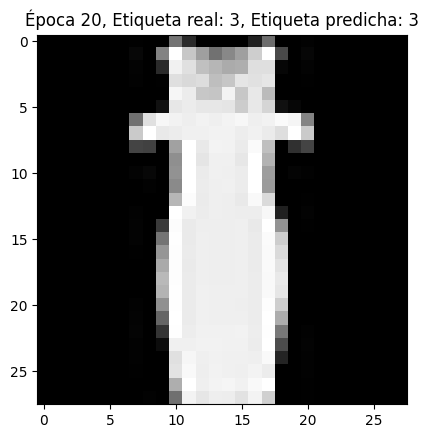

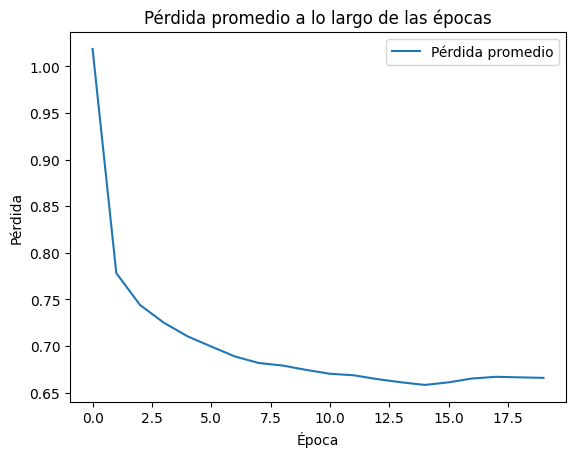

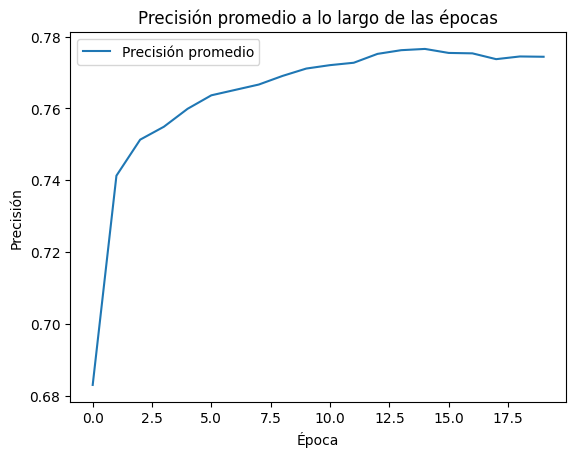

In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (Fashion MNIST dataset):
dataLoader = keras.datasets.fashion_mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
features = features
testFeatures = testFeatures
onehot_testLabels = np.zeros((testLabels.shape[0], 10))
onehot_testLabels[np.arange(testLabels.shape[0]), testLabels] = 1
testLabels = onehot_testLabels

# Set the parameters:
NumClasses = 10
BatchLength = 16
Size = [28, 28, 1]
NumIteration = 100
LearningRate = 1e-4
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)  # Con estas líneas utilizando tf.keras.layers.BatchNormalization
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.int32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Crear listas para almacenar la pérdida y la precisión
loss_history = []
accuracy_history = []

# Dividir conjunto de entrenamiento y conjunto de prueba
split_ratio = 1.0
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Barajar y dividir conjunto de entrenamiento en lotes
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print(f'Época {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calcular la pérdida y precisión promedio de la época
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Agregar la pérdida y precisión promedio a las listas
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)

        print(f'Pérdida promedio: {average_loss}, Precisión promedio: {average_accuracy}')

    # Después de imprimir la forma de la salida
    print("Forma de la salida:", FC.shape)

    # Visualizar algunas imágenes y sus predicciones
    num_visualize = 5  # Puedes ajustar el número de imágenes a visualizar

    # Seleccionar aleatoriamente algunas muestras del conjunto de prueba
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Crear una sesión sin inicializar explícitamente las variables
    for i in visualize_indices:
        # Obtener la imagen y la etiqueta verdadera
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocesar la entrada para que sea compatible con la red neuronal
        input_image = np.reshape(input_image, [1] + Size)

        # Obtener la predicción del modelo
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualizar la imagen, la etiqueta verdadera y la predicción
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Época {epoch}, Etiqueta real: {np.argmax(true_label)}, Etiqueta predicha: {prediction[0]}')
        plt.show()
        plt.pause(2)  # Pausa de 2 segundos entre imágenes

# Graficar la pérdida promedio
plt.plot(average_loss_history, label='Pérdida promedio')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida promedio a lo largo de las épocas')
plt.legend()
plt.show()

# Graficar la precisión promedio
plt.plot(average_accuracy_history, label='Precisión promedio')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión promedio a lo largo de las épocas')
plt.legend()
plt.show()

In [ ]:
def contar_lineas(valores):
    # Convertir la lista a un string separado por saltos de línea
    texto = '\n'.join(map(str, valores)) + '\n'

    # Contar las líneas
    num_lineas = texto.count('\n')

    return num_lineas

# Ejemplo de uso con tus valores
valores = [9.540982, 8.155752, 7.055095, 6.336835, 5.3736587, 4.5594854, 4.7140155, 3.767756, 3.6599443, 3.762139, 3.7850187, 3.1073523, 2.9138782, 3.0609174, 2.7848418, 2.6659322, 2.7153106, 2.3743618, 2.4914336, 2.6024747, 2.3936877, 2.3276732, 2.2821746, 2.0088394, 2.160755, 2.0857751, 1.8749845, 1.8946271, 1.9380292, 1.819306, 1.6819072, 1.8382353, 1.9084914, 1.8359896, 1.7126998, 1.7307271, 1.5054727, 1.646821, 1.7646761, 1.5566751, 1.6523188, 1.4828776, 1.691987, 1.521975, 1.6208559, 1.5815318, 1.483817, 1.5174702, 1.5009061, 1.4264516, 1.4418052, 1.4222277, 1.434852, 1.4692857, 1.4074576, 1.3624986, 1.3002504, 1.4389503, 1.3624806, 1.1947379, 1.2684426, 1.3380628, 1.1813629, 1.2327591, 1.2936959, 1.3103353, 1.3385298, 1.363852, 1.3163258, 1.2367759, 1.2169598, 1.2463655, 1.2440968, 1.238381, 1.2291158, 1.2619476, 1.146483, 1.1771798, 1.1820167, 1.2272276, 1.1029077, 1.1087105, 1.2718396, 1.1830235, 1.1386796, 1.0711523, 1.0777953, 1.1495268, 1.2176257, 1.1443512, 1.0929736, 1.1676915, 1.1236145, 1.1328532, 1.1746216, 1.1400272, 1.077488, 1.1526265, 1.1158648, 1.1355261]

# Contar líneas
num_lineas = contar_lineas(valores)

print(f'El número de líneas es: {num_lineas}')


El número de líneas es: 100


# DIGITOS CON EPOCAS

Instructions for updating:
non-resource variables are not supported in the long term


11490434/11490434 [==============================] - 1s 0us/step


Instructions for updating:
Colocations handled automatically by placer.


Epoch 1
Average Loss: 2.0857093334198, Average Accuracy: 0.3838333487510681
Epoch 2
Average Loss: 1.325006127357483, Average Accuracy: 0.5609500408172607
Epoch 3
Average Loss: 1.1581811904907227, Average Accuracy: 0.6243166327476501
Epoch 4
Average Loss: 1.027097463607788, Average Accuracy: 0.6734499335289001
Epoch 5
Average Loss: 0.9270353317260742, Average Accuracy: 0.7092000246047974
Epoch 6
Average Loss: 0.8563536405563354, Average Accuracy: 0.73253333568573
Epoch 7
Average Loss: 0.8003763556480408, Average Accuracy: 0.7527832984924316
Epoch 8
Average Loss: 0.7625939846038818, Average Accuracy: 0.7676166296005249
Epoch 9
Average Loss: 0.7342824935913086, Average Accuracy: 0.7765167355537415
Epoch 10
Average Loss: 0.7100691199302673, Average Accuracy: 0.7853667140007019
Epoch 11
Average Loss: 0.6896997094154358, Average Accuracy: 0.7919000387191772
Epoch 12
Average Loss: 0.6725051999092102, Average Accuracy: 0.7978833913803101
Epoch 13
Average Loss: 0.6571365594863892, Average Accur

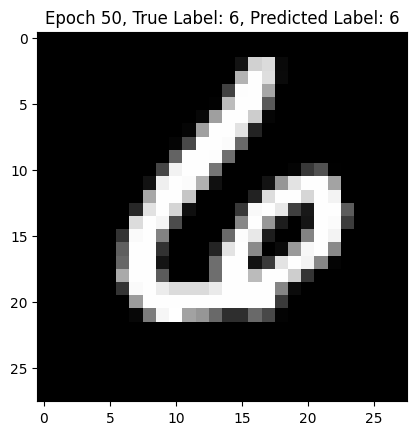

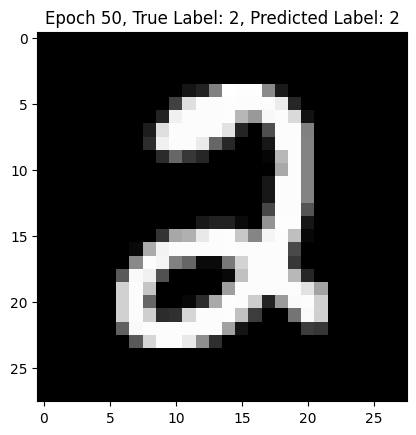

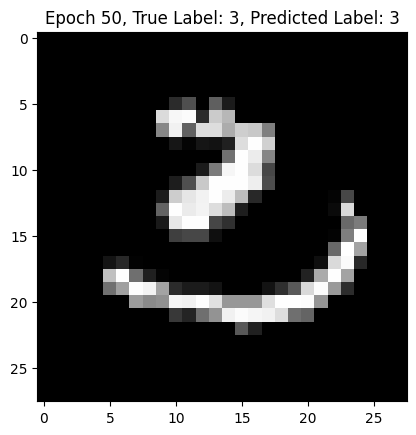

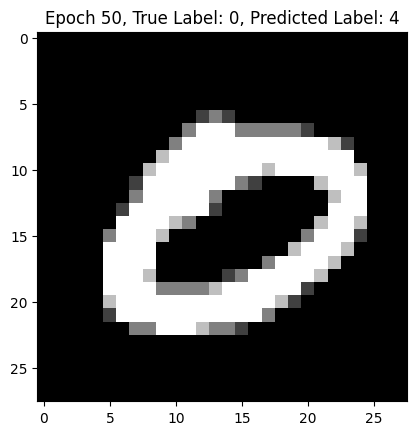

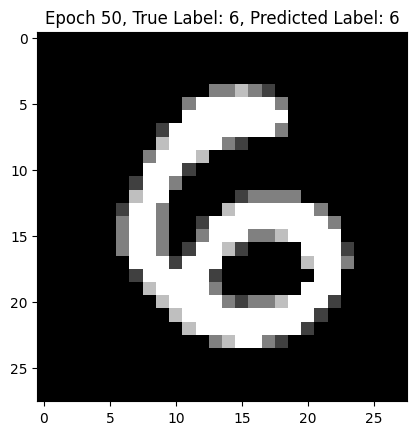

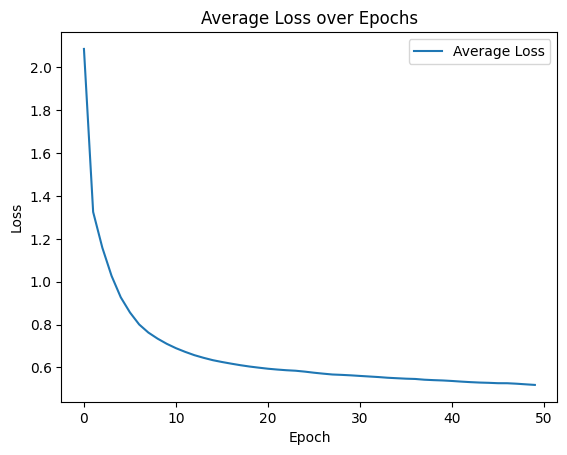

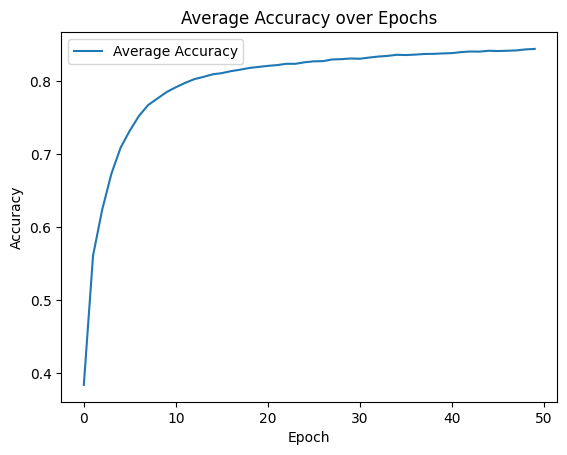

In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
testLabels = keras.utils.to_categorical(testLabels, 10)

# Set the parameters:
NumClasses = 10
BatchLength = 60
Size = [28, 28, 1]
NumIteration = 50
LearningRate = 1e-4                       #Se puede cambiar a 1e-4 IMPORTANTE  DE HECHO QUIZAS MEJOR
#NumKernels = [16, 32, 64]
NumKernels = [14, 7, 3]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Split training and test sets
split_ratio = 1.0
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []


with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calculate average loss and accuracy for the epoch
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)

        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')
        SumAcc = 0.0
        if (epoch>25):
          for i in range(0, testFeatures.shape[0]):
              batch_xs = testFeatures[i, :]
              batch_ys = testLabels[i, :]
              batch_xs = np.reshape(batch_xs, [1]+Size)
              batch_ys = np.reshape(batch_ys, [1, NumClasses])
              a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
              SumAcc += a
          print("Independent Test set: " + str(float(SumAcc) / testFeatures.shape[0]))


    # After printing the shape of the output
    print("Output Shape:", FC.shape)

    # Visualize some images and their predictions
    num_visualize = 5  # You can adjust the number of images to visualize

    # Randomly select some samples from the test set
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Create a session without explicitly initializing variables
    # Evaluate on the test set

    for i in visualize_indices:
        # Get the image and true label
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocess the input to make it compatible with the neural network
        input_image = np.reshape(input_image, [1] + Size)

        # Get the model's prediction
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualize the image, true label, and prediction
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Epoch {epoch}, True Label: {np.argmax(true_label)}, Predicted Label: {prediction[0]}')
        plt.show()
        plt.pause(2)  # 2 seconds pause between images

# Plot average loss
plt.plot(average_loss_history, label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs')
plt.legend()
plt.show()

# Plot average accuracy
plt.plot(average_accuracy_history, label='Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epochs')
plt.legend()
plt.show()


# VALID

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
testLabels = keras.utils.to_categorical(testLabels, 10)

# Set the parameters:
NumClasses = 10
BatchLength = 60
Size = [28, 28, 1]
NumIteration = 50
LearningRate = 1e-4
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels
ValInputData = tf.placeholder(tf.float32, [None] + Size)  # input images for validation
ValOneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # labels for validation

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))
    ValLoss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=ValOneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))
    ValCorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(ValOneHotLabels, 1))
    ValAccuracy = tf.reduce_mean(tf.cast(ValCorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []
val_loss_history = []
val_accuracy_history = []

# Split training and test sets
split_ratio = 0.8
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]

# Shuffle and divide validation set into batches
val_indices = np.arange(val_features.shape[0])
np.random.shuffle(val_indices)

val_batches = [val_indices[i:i + BatchLength] for i in range(0, len(val_indices), BatchLength)]

Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []


with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []
        val_losses = []
        val_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calculate average loss and accuracy for the epoch on the training set
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        for val_batch_index in val_batches:
            val_batch_xs = val_features[val_batch_index, :]
            val_batch_ys = val_labels[val_batch_index, :]
            val_batch_xs = np.reshape(val_batch_xs, [BatchLength, 28, 28, 1])
            val_Acc, val_L = Sess.run([ValAccuracy, ValLoss], feed_dict={ValInputData: val_batch_xs, ValOneHotLabels: val_batch_ys})

            val_accuracies.append(val_Acc)
            val_losses.append(val_L)

        # Evaluate on the validation set
        val_acc = np.mean(val_accuracies)
        val_loss = np.mean(val_losses)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_acc)

        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')
        print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Plot average loss y loss de validación
plt.plot(average_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()

# Plot average accuracy y accuracy de validación
plt.plot(average_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy over Epochs')
plt.legend()
plt.show()


Epoch 1


InvalidArgumentError: Graph execution error:

Detected at node 'Placeholder' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    File "<ipython-input-10-5f011f464c72>", line 73, in <cell line: 73>
Node: 'Placeholder'
Detected at node 'Placeholder' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    File "<ipython-input-10-5f011f464c72>", line 73, in <cell line: 73>
Node: 'Placeholder'
2 root error(s) found.
  (0) INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,28,28,1]
	 [[{{node Placeholder}}]]
	 [[_arg_Placeholder_3_0_1/_8]]
  (1) INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,28,28,1]
	 [[{{node Placeholder}}]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'Placeholder':
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
  File "<ipython-input-10-5f011f464c72>", line 73, in <cell line: 73>
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/array_ops.py", line 3274, in placeholder
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 7073, in placeholder
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/op_def_library.py", line 796, in _apply_op_helper
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 2652, in _create_op_internal
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 1160, in from_node_def


# MAS PROFUNDO

 # LEARNING RATE


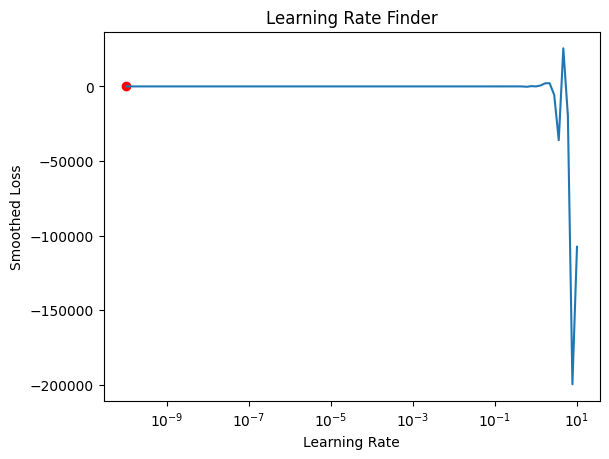

Optimal Learning Rate (Valley): 1e-10
Epoch 1
Average Loss: 111055888.0, Average Accuracy: 0.09930000454187393
Epoch 2
Average Loss: 111055888.0, Average Accuracy: 0.09930000454187393
Epoch 3


KeyboardInterrupt: 

In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
testLabels = keras.utils.to_categorical(testLabels, 10)

# Set the parameters:
NumClasses = 10
BatchLength = 60
Size = [28, 28, 1]
NumIteration = 50
LearningRate = 1e-6
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


def find_valley(sess, optimizer, loss, input_data, one_hot_labels, learning_rate, start_lr=1e-10, end_lr=1e1, num_batches=100, beta=0.98):
    lr_schedule = np.geomspace(start_lr, end_lr, num=num_batches)
    losses = []
    avg_loss = 0.0

    for i in range(num_batches):
        # Genera un lote aleatorio (puedes ajustar esta parte según tus datos)
        batch_xs = np.random.randn(BatchLength, 28, 28, 1)
        batch_ys = np.random.randn(BatchLength, NumClasses)

        lr = lr_schedule[i]
        _, current_loss = sess.run([optimizer, loss], feed_dict={input_data: batch_xs, one_hot_labels: batch_ys, learning_rate: lr})
        avg_loss = beta * avg_loss + (1 - beta) * current_loss
        smoothed_loss = avg_loss / (1 - beta**(i + 1))
        losses.append(smoothed_loss)

    # Encuentra el "valle" en lugar del mínimo
    derivatives = np.gradient(losses)
    valley_index = np.argmax(derivatives < 0)  # Encuentra el índice donde la derivada es negativa

    return lr_schedule, losses, valley_index


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels
learning_rate_ph = tf.placeholder(tf.float32, shape=[])

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(learning_rate_ph).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Split training and test sets
split_ratio = 1.0
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)

    # Encontrar la tasa de aprendizaje óptima (valle)
    lr_schedule, losses, valley_index = find_valley(Sess, Optimizer, Loss, InputData, OneHotLabels, learning_rate_ph)

    # Visualizar la pérdida en función de la tasa de aprendizaje
    plt.plot(lr_schedule, losses)
    plt.scatter(lr_schedule[valley_index], losses[valley_index], color='red')  # Marca el punto en el "valle"
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Smoothed Loss')
    plt.title('Learning Rate Finder')
    plt.show()

    # Usar la tasa de aprendizaje en el "valle"
    optimal_lr = lr_schedule[valley_index]

    print(f'Optimal Learning Rate (Valley): {optimal_lr}')

    # Entrenar el modelo con la tasa de aprendizaje óptima (valle)
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys, learning_rate_ph: optimal_lr})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calculate average loss and accuracy for the epoch
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)

        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')

    # After printing the shape of the output
    print("Output Shape:", FC.shape)

    # Visualize some images and their predictions
    num_visualize = 5  # You can adjust the number of images to visualize

    # Randomly select some samples from the test set
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Create a session without explicitly initializing variables
    for i in visualize_indices:
        # Get the image and true label
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocess the input to make it compatible with the neural network
        input_image = np.reshape(input_image, [1] + Size)

        # Get the model's prediction
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualize the image, true label, and prediction
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Epoch {epoch}, True Label: {np.argmax(true_label)}, Predicted Label: {prediction[0]}')
        plt.show()
        plt.pause(2)  # 2 seconds pause between images

# Plot average loss
plt.plot(average_loss_history, label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs')
plt.legend()
plt.show()

# Plot average accuracy
plt.plot(average_accuracy_history, label='Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epochs')
plt.legend()
plt.show()




# VALID


In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
testLabels = keras.utils.to_categorical(testLabels, 10)

# Set the parameters:
NumClasses = 10
BatchLength = 60
Size = [28, 28, 1]
NumIteration = 50
LearningRate = 1e-4                       #Se puede cambiar a 1e-4 IMPORTANTE  DE HECHO QUIZAS MEJOR
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Split training and test sets
split_ratio = 0.8
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []


with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calculate average loss and accuracy for the epoch
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)

        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')

    # After printing the shape of the output
    print("Output Shape:", FC.shape)

    # Visualize some images and their predictions
    num_visualize = 5  # You can adjust the number of images to visualize

    # Randomly select some samples from the test set
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Create a session without explicitly initializing variables
    # Evaluate on the test set
    test_acc, test_loss = Sess.run([Accuracy, Loss], feed_dict={InputData: testFeatures, OneHotLabels: testLabels})
    print(f'Test Accuracy: {test_acc}, Test Loss: {test_loss}')

    for i in visualize_indices:
        # Get the image and true label
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocess the input to make it compatible with the neural network
        input_image = np.reshape(input_image, [1] + Size)

        # Get the model's prediction
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualize the image, true label, and prediction
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Epoch {epoch}, True Label: {np.argmax(true_label)}, Predicted Label: {prediction[0]}')
        plt.show()
        plt.pause(2)  # 2 seconds pause between images

# Plot average loss
plt.plot(average_loss_history, label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs')
plt.legend()
plt.show()

# Plot average accuracy
plt.plot(average_accuracy_history, label='Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epochs')
plt.legend()
plt.show()


# CONVOLUCIONES DIRECTAS

In [ ]:
from fastai.vision.all import *

# Load training and test data (MNIST dataset):
path = untar_data(URLs.MNIST)
items = get_image_files(path)
lbls = items.map(lambda x: int(x.parent.name))

# Specify that we want images in grayscale
dls = ImageDataLoaders.from_lists(path, items, lbls, valid_pct=0.2, seed=42, item_tfms=Resize(28), color='grayscale')

# Set the parameters:
NumClasses = 10
NumEpochs = 50
LearningRate = 1e-4
NumKernels = [14, 7, 3]  # Change the kernel sizes here

# Define the model architecture
model = nn.Sequential(
    nn.Conv2d(3, NumKernels[0], kernel_size=14, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(NumKernels[0], NumKernels[1], kernel_size=7, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(NumKernels[1], NumKernels[2], kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),  # Add adaptive pooling to match the input size for the linear layer
    nn.Flatten(),
    nn.Linear(NumKernels[2], NumClasses)
)

print("Input shape before training:", dls.one_batch()[0].shape)

# Create a learner
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy, cbs=[BnFreeze])

# Train the model
learn.fit_one_cycle(NumEpochs, lr_max=LearningRate)


Input shape before training: torch.Size([64, 3, 28, 28])


epoch,train_loss,valid_loss,accuracy,time


RuntimeError: Given groups=1, weight of size [16, 1, 14, 14], expected input[64, 3, 28, 28] to have 1 channels, but got 3 channels instead

# KERNEL 3

In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
testLabels = keras.utils.to_categorical(testLabels, 10)

# Set the parameters:
NumClasses = 10
BatchLength = 60
Size = [28, 28, 1]
NumIteration = 10
LearningRate = 1e-4                       #Se puede cambiar a 1e-4 IMPORTANTE  DE HECHO QUIZAS MEJOR
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)

def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    print("Dimensiones del kernel w:", w.get_shape().as_list())

    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out



tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Split training and test sets
split_ratio = 1.0
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []


with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calculate average loss and accuracy for the epoch
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)

        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')
        SumAcc = 0.0
    for i in range(0, testFeatures.shape[0]):
        batch_xs = testFeatures[i, :]
        batch_ys = testLabels[i, :]
        batch_xs = np.reshape(batch_xs, [1]+Size)
        batch_ys = np.reshape(batch_ys, [1, NumClasses])
        a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
        SumAcc += a
    print("Independent Test set: " + str(float(SumAcc) / testFeatures.shape[0]))


    # After printing the shape of the output
    print("Output Shape:", FC.shape)

    # Visualize some images and their predictions
    num_visualize = 5  # You can adjust the number of images to visualize

    # Randomly select some samples from the test set
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Create a session without explicitly initializing variables
    # Evaluate on the test set

    for i in visualize_indices:
        # Get the image and true label
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocess the input to make it compatible with the neural network
        input_image = np.reshape(input_image, [1] + Size)

        # Get the model's prediction
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualize the image, true label, and prediction
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Epoch {epoch}, True Label: {np.argmax(true_label)}, Predicted Label: {prediction[0]}')
        plt.show()
        plt.pause(2)  # 2 seconds pause between images

# Plot average loss
plt.plot(average_loss_history, label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs')
plt.legend()
plt.show()

# Plot average accuracy
plt.plot(average_accuracy_history, laconvolution_in_freq_domain_without_ifftbel='Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epochs')
plt.legend()
plt.show()


Dimensiones del kernel w: [14, 14, 1, 16]
Dimensiones del kernel w: [7, 7, 16, 32]
Dimensiones del kernel w: [3, 3, 32, 64]


KeyboardInterrupt: 

In [ ]:
from fastai.vision.all import *

# Load training and test data (MNIST dataset):
path = untar_data(URLs.MNIST)
items = get_image_files(path)
lbls = items.map(lambda x: int(x.parent.name))

# Specify that we want images in grayscale
dls = ImageDataLoaders.from_lists(path, items, lbls, valid_pct=0.2, seed=42, item_tfms=Resize(28), color='grayscale')

# Set the parameters:
NumClasses = 10
NumEpochs = 10
LearningRate = 1e-4
NumKernels = [16, 32, 64]

# Specify that we want images in grayscale

# Define the model architecture
model = nn.Sequential(
    nn.Conv2d(1, NumKernels[0], kernel_size=14, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(NumKernels[0], NumKernels[1], kernel_size=7, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(NumKernels[1], NumKernels[2], kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(NumKernels[2], NumClasses)
)

# Create a Learner
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

# Train the model
learn.fit_one_cycle(NumEpochs, lr_max=LearningRate)


epoch,train_loss,valid_loss,accuracy,time


RuntimeError: Given groups=1, weight of size [16, 1, 14, 14], expected input[64, 3, 28, 28] to have 1 channels, but got 3 channels instead

# una


Size of w: [14, 14, 1, 1]
Epoch 1
Average Loss: 4.2557902336120605, Average Accuracy: 0.2982666492462158
Epoch 2
Average Loss: 1.3176953792572021, Average Accuracy: 0.6133667230606079
Epoch 3
Average Loss: 0.8898823261260986, Average Accuracy: 0.7330499887466431
Epoch 4
Average Loss: 0.6979240775108337, Average Accuracy: 0.7982833385467529
Epoch 5
Average Loss: 0.5781223773956299, Average Accuracy: 0.8388499617576599
Epoch 6
Average Loss: 0.4921616315841675, Average Accuracy: 0.8661333322525024
Epoch 7
Average Loss: 0.42815691232681274, Average Accuracy: 0.8845000267028809
Epoch 8
Average Loss: 0.38117945194244385, Average Accuracy: 0.8980833292007446
Epoch 9
Average Loss: 0.3456721901893616, Average Accuracy: 0.9079833030700684
Epoch 10
Average Loss: 0.31736400723457336, Average Accuracy: 0.914816677570343
Epoch 11
Average Loss: 0.29480788111686707, Average Accuracy: 0.9205166101455688
Epoch 12
Average Loss: 0.2767038941383362, Average Accuracy: 0.9251999258995056
Epoch 13
Average Los

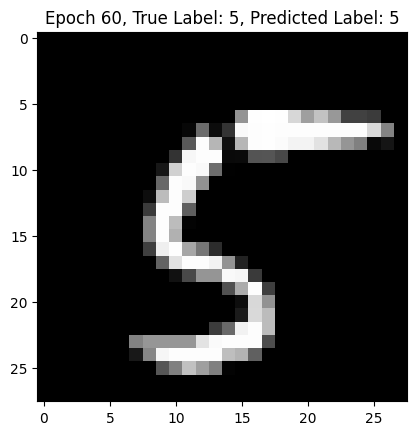

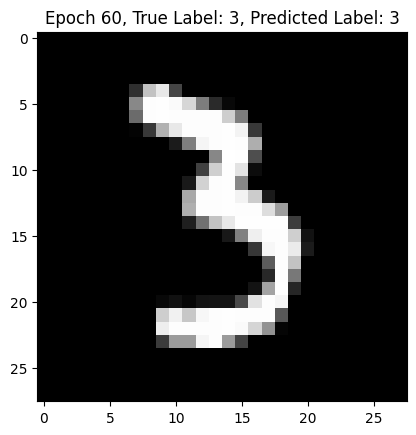

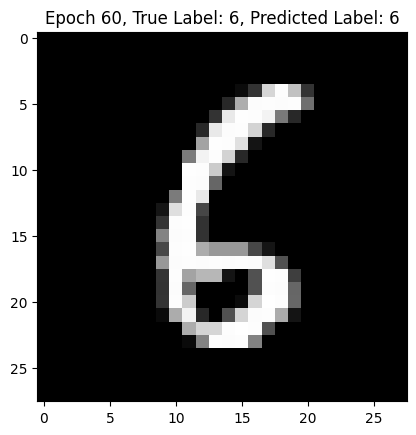

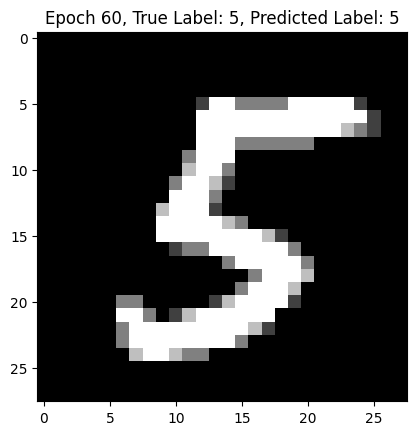

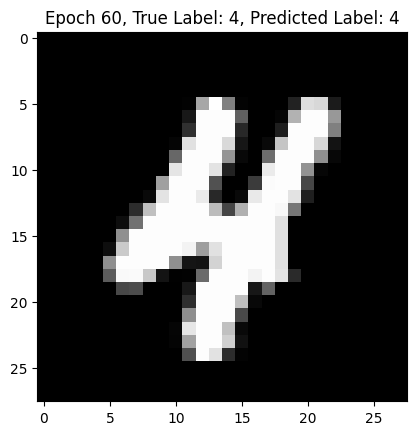

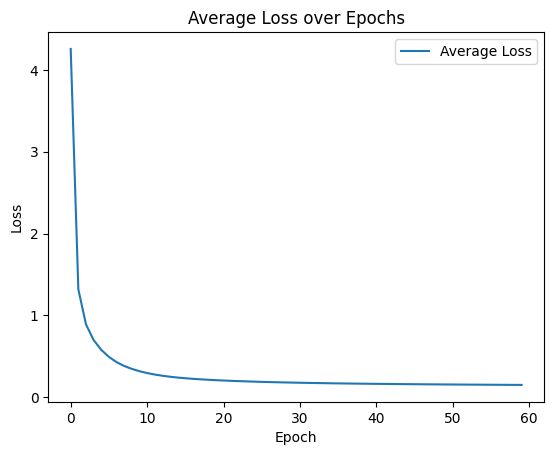

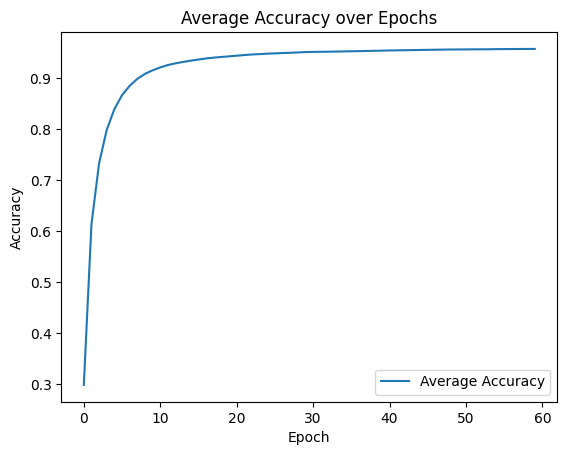

In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
testLabels = keras.utils.to_categorical(testLabels, 10)

# Set the parameters:
NumClasses = 10
BatchLength = 60
Size = [28, 28, 1]
NumIteration = 60
LearningRate = 1e-4
NumKernels = [1]  # Cambiado a una sola capa y un canal de salida

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0

def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)

def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    print("Size of w:", w.get_shape().as_list())
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out

tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Split training and test sets
split_ratio = 1.0
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)
        SumAcc=0
        if (epoch>25):
          for i in range(0, testFeatures.shape[0]):
              batch_xs = testFeatures[i, :]
              batch_ys = testLabels[i, :]
              batch_xs = np.reshape(batch_xs, [1]+Size)
              batch_ys = np.reshape(batch_ys, [1, NumClasses])
              a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
              SumAcc += a
          print("Independent Test set: " + str(float(SumAcc) / testFeatures.shape[0]))


        # Calculate average loss and accuracy for the epoch
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)

        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')



    # After printing the shape of the output
    print("Output Shape:", FC.shape)

    # Visualize some images and their predictions
    num_visualize = 5  # You can adjust the number of images to visualize

    # Randomly select some samples from the test set
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Create a session without explicitly initializing variables
    # Evaluate on the test set
    for i in visualize_indices:
        # Get the image and true label
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocess the input to make it compatible with the neural network
        input_image = np.reshape(input_image, [1] + Size)

        # Get the model's prediction
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualize the image, true label, and prediction
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Epoch {epoch}, True Label: {np.argmax(true_label)}, Predicted Label: {prediction[0]}')
        plt.show()
        plt.pause(2)  # 2 seconds pause between images

# Plot average loss
plt.plot(average_loss_history, label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs')
plt.legend()
plt.show()

# Plot average accuracy
plt.plot(average_accuracy_history, label='Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epochs')
plt.legend()
plt.show()


Size of w: [14, 14, 1, 1]
Epoch 1
Average Loss: 3.5102293491363525, Average Accuracy: 0.9425333142280579
Epoch 2
Average Loss: 1.2372924089431763, Average Accuracy: 0.9425333142280579
Epoch 3
Average Loss: 0.8277289867401123, Average Accuracy: 0.9425333142280579
Epoch 4
Average Loss: 0.6449950933456421, Average Accuracy: 0.9425333142280579
Epoch 5
Average Loss: 0.540623664855957, Average Accuracy: 0.9425333142280579
Epoch 6
Average Loss: 0.4724442660808563, Average Accuracy: 0.9425333142280579
Epoch 7
Average Loss: 0.42394623160362244, Average Accuracy: 0.9425333142280579
Epoch 8
Average Loss: 0.3867833912372589, Average Accuracy: 0.9425333142280579
Epoch 9
Average Loss: 0.35666096210479736, Average Accuracy: 0.9425333142280579
Epoch 10
Average Loss: 0.33184143900871277, Average Accuracy: 0.9425333142280579
Epoch 11
Average Loss: 0.3110177516937256, Average Accuracy: 0.9425333142280579
Epoch 12
Average Loss: 0.29328280687332153, Average Accuracy: 0.9425333142280579
Epoch 13
Average Los

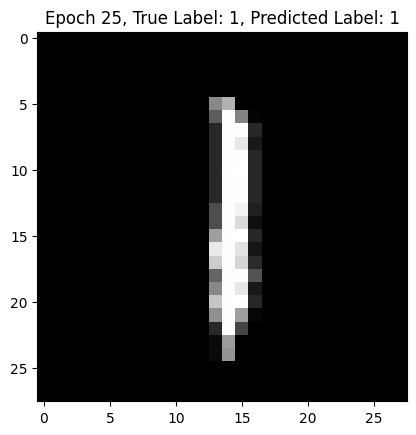

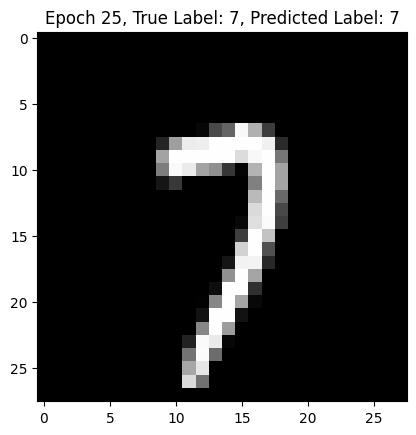

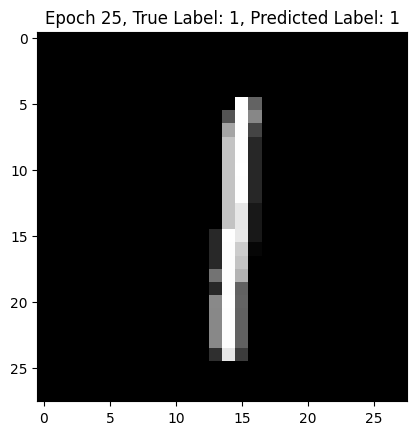

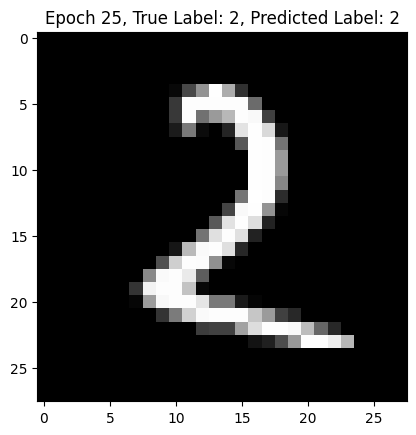

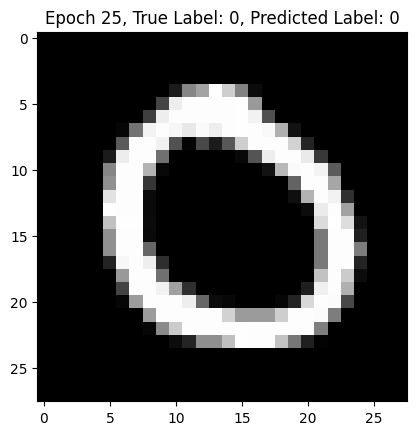

Tiempo total de entrenamiento: 63.36512875556946 segundos


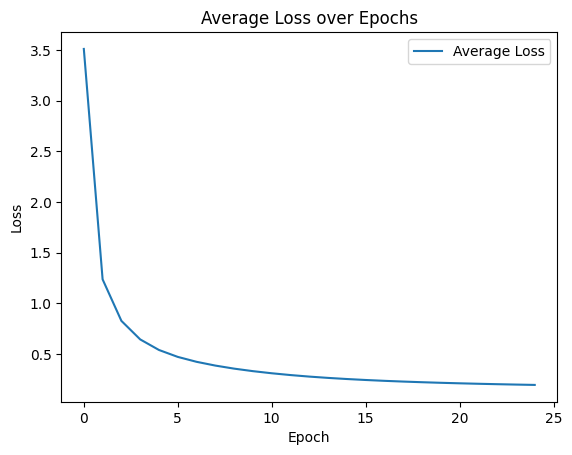

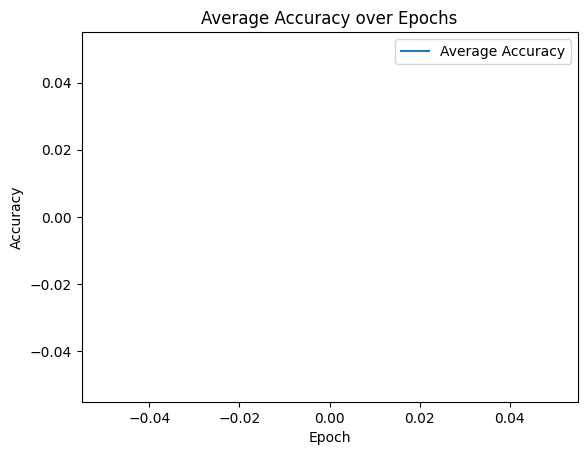

In [ ]:
#PRUEBA
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
testLabels = keras.utils.to_categorical(testLabels, 10)

# Set the parameters:
NumClasses = 10
BatchLength = 60
Size = [28, 28, 1]
NumIteration = 25 #30
LearningRate = 1e-4
NumKernels = [1]  # Cambiado a una sola capa y un canal de salida

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0

def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)

def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    print("Size of w:", w.get_shape().as_list())
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out

tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Split training and test sets
split_ratio = 1.0
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []
start_time=0
end_time=0
training_time=0
with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    start_time = time.time()
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calculate average loss and accuracy for the epoch
        average_loss = np.mean(epoch_losses)
        #average_accuracy = np.mean(epoch_accuracies)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        #average_accuracy_history.append(average_accuracy)

        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')
    end_time = time.time()
    SumAcc=0
    for i in range(0, testFeatures.shape[0]):
      batch_xs = testFeatures[i, :]
      batch_ys = testLabels[i, :]
      batch_xs = np.reshape(batch_xs, [1]+Size)
      batch_ys = np.reshape(batch_ys, [1, NumClasses])
      a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
      SumAcc += a
    print("Independent Test set: " + str(float(SumAcc) / testFeatures.shape[0]))



    # After printing the shape of the output
    print("Output Shape:", FC.shape)

    # Visualize some images and their predictions
    num_visualize = 5  # You can adjust the number of images to visualize

    # Randomly select some samples from the test set
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Create a session without explicitly initializing variables
    # Evaluate on the test set
    for i in visualize_indices:
        # Get the image and true label
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocess the input to make it compatible with the neural network
        input_image = np.reshape(input_image, [1] + Size)

        # Get the model's prediction
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualize the image, true label, and prediction
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Epoch {epoch}, True Label: {np.argmax(true_label)}, Predicted Label: {prediction[0]}')
        plt.show()
        plt.pause(2)  # 2 seconds pause between images


training_time = end_time - start_time
print("Tiempo total de entrenamiento:", training_time, "segundos")

# Plot average loss
plt.plot(average_loss_history, label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs')
plt.legend()
plt.show()

# Plot average accuracy
plt.plot(average_accuracy_history, label='Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epochs')
plt.legend()
plt.show()

In [ ]:

# Define una variable para almacenar el tiempo de inicio
start_time = time.time()

# Resto de tu código de entrenamiento aquí

# Después de que termine el entrenamiento, calcula el tiempo transcurrido
end_time = time.time()


In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
testLabels = keras.utils.to_categorical(testLabels, 10)

# Set the parameters:
NumClasses = 10
BatchLength = 60
Size = [28, 28, 1]
NumIteration = 60
LearningRate = 1e-4
NumKernels = [1,2]  # Cambiado a una sola capa y un canal de salida

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0

def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)

def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    print("Size of w:", w.get_shape().as_list())
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out

tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Split training and test sets
split_ratio = 1.0
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)
        SumAcc=0
        if (epoch>25):
          for i in range(0, testFeatures.shape[0]):
              batch_xs = testFeatures[i, :]
              batch_ys = testLabels[i, :]
              batch_xs = np.reshape(batch_xs, [1]+Size)
              batch_ys = np.reshape(batch_ys, [1, NumClasses])
              a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
              SumAcc += a
          print("Independent Test set: " + str(float(SumAcc) / testFeatures.shape[0]))


        # Calculate average loss and accuracy for the epoch
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)

        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')



    # After printing the shape of the output
    print("Output Shape:", FC.shape)

    # Visualize some images and their predictions
    num_visualize = 5  # You can adjust the number of images to visualize

    # Randomly select some samples from the test set
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Create a session without explicitly initializing variables
    # Evaluate on the test set
    for i in visualize_indices:
        # Get the image and true label
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocess the input to make it compatible with the neural network
        input_image = np.reshape(input_image, [1] + Size)

        # Get the model's prediction
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualize the image, true label, and prediction
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Epoch {epoch}, True Label: {np.argmax(true_label)}, Predicted Label: {prediction[0]}')
        plt.show()
        plt.pause(2)  # 2 seconds pause between images

# Plot average loss
plt.plot(average_loss_history, label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs')
plt.legend()
plt.show()

# Plot average accuracy
plt.plot(average_accuracy_history, label='Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epochs')
plt.legend()
plt.show()

Size of w: [14, 14, 1, 1]
Size of w: [7, 7, 1, 2]
Epoch 1
Average Loss: 2.9624602794647217, Average Accuracy: 0.3051999807357788
Epoch 2
Average Loss: 1.1804250478744507, Average Accuracy: 0.6316666007041931
Epoch 3
Average Loss: 0.8723790645599365, Average Accuracy: 0.7434999942779541
Epoch 4
Average Loss: 0.7130056619644165, Average Accuracy: 0.8041666746139526
Epoch 5
Average Loss: 0.5993620157241821, Average Accuracy: 0.8412333130836487
Epoch 6
Average Loss: 0.5126925110816956, Average Accuracy: 0.8654000163078308
Epoch 7
Average Loss: 0.4458845257759094, Average Accuracy: 0.8810999989509583
Epoch 8
Average Loss: 0.3958560526371002, Average Accuracy: 0.8936833739280701
Epoch 9
Average Loss: 0.35873398184776306, Average Accuracy: 0.9027332663536072
Epoch 10
Average Loss: 0.33088794350624084, Average Accuracy: 0.9103166460990906
Epoch 11
Average Loss: 0.3096296489238739, Average Accuracy: 0.9156500101089478
Epoch 12
Average Loss: 0.2928820848464966, Average Accuracy: 0.92006665468215

KeyboardInterrupt: 

In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
testLabels = keras.utils.to_categorical(testLabels, 10)

# Set the parameters:
NumClasses = 10
BatchLength = 60
Size = [28, 28, 1]
NumIteration = 60
LearningRate = 1e-4
NumKernels = [1]  # Cambiado a una sola capa y un canal de salida

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0

def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)

def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    print("Size of w:", w.get_shape().as_list())
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out

tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Split training and test sets
split_ratio = 1.0
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)
        SumAcc=0
        if (epoch>25):
          for i in range(0, testFeatures.shape[0]):
              batch_xs = testFeatures[i, :]
              batch_ys = testLabels[i, :]
              batch_xs = np.reshape(batch_xs, [1]+Size)
              batch_ys = np.reshape(batch_ys, [1, NumClasses])
              a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
              SumAcc += a
          print("Independent Test set: " + str(float(SumAcc) / testFeatures.shape[0]))


        # Calculate average loss and accuracy for the epoch
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)

        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')



    # After printing the shape of the output
    print("Output Shape:", FC.shape)

    # Visualize some images and their predictions
    num_visualize = 5  # You can adjust the number of images to visualize

    # Randomly select some samples from the test set
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Create a session without explicitly initializing variables
    # Evaluate on the test set
    for i in visualize_indices:
        # Get the image and true label
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocess the input to make it compatible with the neural network
        input_image = np.reshape(input_image, [1] + Size)

        # Get the model's prediction
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualize the image, true label, and prediction
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Epoch {epoch}, True Label: {np.argmax(true_label)}, Predicted Label: {prediction[0]}')
        plt.show()
        plt.pause(2)  # 2 seconds pause between images

# Plot average loss
plt.plot(average_loss_history, label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs')
plt.legend()
plt.show()

# Plot average accuracy
plt.plot(average_accuracy_history, label='Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epochs')
plt.legend()
plt.show()


AttributeError: type object 'ImageDataLoaders' has no attribute 'from_tensors'

In [ ]:
from fastai.vision.all import *
from PIL import Image

# Resto del código...


10


epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7bb8be6fee60> (for post_execute):


KeyboardInterrupt: 

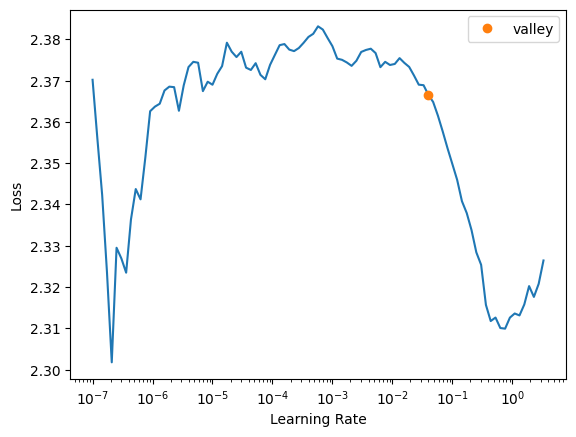

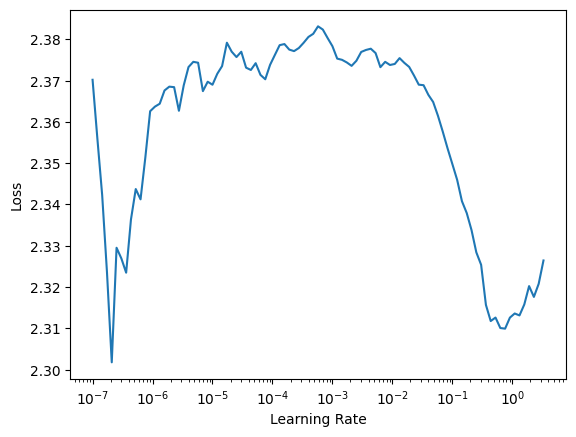

In [ ]:
from fastai.vision.all import *

# Load training and test data (MNIST dataset):
path = untar_data(URLs.MNIST)

# Specify that we want images in grayscale
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(28), color='grayscale')
print(dls.c)

# Set the parameters
NumClasses = dls.c
NumEpochs = 30

# Define the model architecture
model = nn.Sequential(
    nn.Conv2d(3, 1, kernel_size=14),  # Cambiado el número de canales de entrada
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(1, NumClasses)  # Ajustado el número de entradas de la capa lineal
)

# Create a Learner
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

# Find the learning rate
lr_min = learn.lr_find()
learn.recorder.plot_lr_find()

# Train the model using fit_one_cycle with the minimum learning rate in the valley
learn.fit_one_cycle(NumEpochs, lr_max=lr_min)

# Hacer algunas predicciones en el conjunto de prueba
preds, targets = learn.get_preds()
accuracy_test = accuracy(preds, targets)
print(f'Accuracy on test set: {accuracy_test.item()}')



In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import tensorflow_datasets as tfds

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Función para cargar el conjunto de datos Medical MNIST
def load_medical_mnist():
    # Carga el conjunto de datos Medical MNIST de TensorFlow Datasets
    dataset, info = tfds.load('moving_mnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

    # Divide el conjunto de datos en datos de entrenamiento y prueba
    train_dataset, test_dataset = dataset

    # Define listas para almacenar características y etiquetas
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []

    # Recorre el conjunto de datos de entrenamiento y carga las características y etiquetas
    for features, labels in train_dataset:
        train_features.append(features.numpy())
        train_labels.append(labels.numpy())

    # Recorre el conjunto de datos de prueba y carga las características y etiquetas
    for features, labels in test_dataset:
        test_features.append(features.numpy())
        test_labels.append(labels.numpy())

    # Convierte las listas a matrices numpy
    train_features = np.array(train_features)
    train_labels = np.array(train_labels)
    test_features = np.array(test_features)
    test_labels = np.array(test_labels)

    return (train_features, train_labels), (test_features, test_labels)

# Load Medical MNIST dataset
(features, labels), (testFeatures, testLabels) = load_medical_mnist()

# Set the parameters:
NumClasses = 6  # There are 6 classes in Medical MNIST
BatchLength = 60
Size = [64, 64, 1]  # Adjust the size accordingly
NumIteration = 20  # Number of training iterations
LearningRate = 1e-4
NumKernels = [1]  # Changed to a single layer and single output channel

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0

def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)

def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    print("Size of w:", w.get_shape().as_list())
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out

tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Split training and test sets
split_ratio = 0.8  # You can adjust this split ratio as needed
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []
start_time = 0
end_time = 0
training_time = 0
with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    start_time = time.time()
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength] + Size)
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calculate average loss and accuracy for the epoch
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)

        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')
    end_time = time.time()
    SumAcc = 0
    for i in range(0, testFeatures.shape[0]):
        batch_xs = testFeatures[i, :]
        batch_ys = testLabels[i, :]
        batch_xs = np.reshape(batch_xs, [1] + Size)
        batch_ys = np.reshape(batch_ys, [1, NumClasses])
        a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
        SumAcc += a
    print("Independent Test set: " + str(float(SumAcc) / testFeatures.shape[0]))

    # After printing the shape of the output
    print("Output Shape:", FC.shape)

    # Visualize some images and their predictions
    num_visualize = 5  # You can adjust the number of images to visualize

    # Randomly select some samples from the test set
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Create a session without explicitly initializing variables
    # Evaluate on the test set
    for i in visualize_indices:
        # Get the image and true label
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocess the input to make it compatible with the neural network
        input_image = np.reshape(input_image, [1] + Size)

        # Get the model's prediction
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualize the image, true label, and prediction
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Epoch {epoch}, True Label: {np.argmax(true_label)}, Predicted Label: {prediction[0]}')
        plt.show()
        plt.pause(2)  # 2 seconds pause between images

training_time = end_time - start_time
print("Tiempo total de entrenamiento:", training_time, "segundos")

# Plot average loss
plt.plot(average_loss_history, label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs')
plt.legend()
plt.show()

# Plot average accuracy
plt.plot(average_accuracy_history, label='Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epochs')
plt.legend()
plt.show()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load PatchCamelyon dataset
dataLoader = tfds.load("patch_camelyon", split="train")
data = list(dataLoader)
features = np.array([item['image'] for item in data])
labels = np.array([item['label'] for item in data])

# Convert labels to one-hot encoding
onehot_labels = keras.utils.to_categorical(labels, 2)

# Set the parameters:
NumClasses = 2
BatchLength = 60
Size = [96, 96, 3]  # Image size for PatchCamelyon dataset
NumIteration = 60
LearningRate = 1e-4
NumKernels = [1, 2]  # Changed to a single layer and single output channel

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0

def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)

def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    print("Size of w:", w.get_shape().as_list())
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out

tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Split training and test sets
split_ratio = 0.8
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = onehot_labels[:split_index]

val_features = features[split_index:]
val_labels = onehot_labels[split_index:]

# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength] + Size)
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calculate average loss and accuracy for the epoch
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)

        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')

    # After printing the shape of the output
    print("Output Shape:", FC.shape)

# Plot average loss
plt.plot(average_loss_history, label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs')
plt.legend()
plt.show()

# Plot average accuracy
plt.plot(average_accuracy_history, label='Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epochs')
plt.legend()
plt.show()


Instructions for updating:
non-resource variables are not supported in the long term


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]